In [20]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl

def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)


In [ ]:
#importlib.reload(PeakDetective)

In [3]:
datadir = "../data/covid_plasma/"
resolution = 60
window = 1.0

In [5]:
ms1ppm = 30
peakWidth = (10,83)
s2n = 5
noise = 500
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

,mz,rt
1,52.995260,5.082550
2,54.977009,5.083667
3,55.019199,6.030133
4,57.034543,5.399525
5,57.034540,1.583142
...,...,...
3928,1612.974731,6.589500
3929,1612.974770,2.198033
3930,1613.978781,15.015317
3931,1613.978738,2.198033


In [6]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [7]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

In [ ]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

              mz         rt
3858  981.994780   8.895350
1627  241.118920   1.225717
489   125.010830   5.865008
3683  738.757697  13.071608
3326  540.330435   1.224392
...          ...        ...
2230  297.153315   0.810117
746   152.978154  13.079917
1210  196.938735  11.671600
2442  333.206540   1.185283
1472  224.173400   0.858658

[500 rows x 2 columns]


In [8]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [12]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts)

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [13]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],rts)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [14]:
X_signal = integ.generateSignalPeaks(peakList,raw_data,n=50)
X_noise = integ.generateFalsePeaks(peakList,raw_data,n=50)
X_syn = np.concatenate((X_signal,X_noise),axis=0)
y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])

forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [15]:
pkl.dump([X,X_labeled,y_labeled,X_syn,y_syn],open("../data/model_selection_data.pkl","wb"))

In [9]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open("../data/model_selection_data.pkl","rb"))

In [10]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,20,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/20
1407/1407 [==============================] - 31s 21ms/step - loss: 0.1289 - mean_absolute_error: 0.0555 - val_loss: 0.0834 - val_mean_absolute_error: 0.0178
Epoch 2/20
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0768 - mean_absolute_error: 0.0142 - val_loss: 0.0738 - val_mean_absolute_error: 0.0119
Epoch 3/20
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0730 - mean_absolute_error: 0.0115 - val_loss: 0.0725 - val_mean_absolute_error: 0.0109
Epoch 4/20
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0720 - mean_absolute_error: 0.0108 - val_loss: 0.0717 - val_mean_absolute_error: 0.0105
Epoch 5/20
1407/1407 [==============================] - 30s 22ms/step - loss: 0.0713 - mean_absolute_error: 0.0103 - val_loss: 0.0711 - val_mean_absolute_error: 0.0100
Epoch 6/20
1407/1407 [==================

In [11]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=50)

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds]]

In [12]:
X_labeled_norm = PeakDetective.normalizeMatrix(X_labeled)
X_labeled_smoothed = integ.smoother.predict(PeakDetective.normalizeMatrix(X_labeled))

15/15 [==============================] - 0s 6ms/step


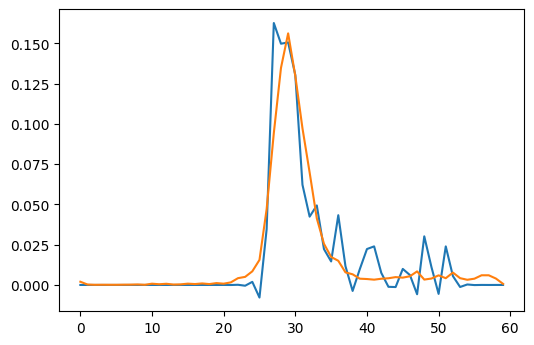

In [13]:
ind = rd.choice(list(range(len(X_labeled))))
plt.plot(X_labeled_norm[ind])
plt.plot(X_labeled_smoothed[ind])

In [14]:
if __name__ == "__main__":
    integ.trainClassifier(X_labeled,y_labeled,X_val,y_val,1000,32,5)

2/2 [==============================] - 0s 4ms/step
loss: 0.5452856421470642 mean_absolute_error: 0.33769407868385315 val loss: 0.4149262607097626 val_mean_absolute_error: 0.23661363124847412 numEpochs: 118


In [15]:
y_val_scores_supervised = integ.classifyMatrix(X_val)

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 23ms/step
loss: 0.423482209444046 mean_absolute_error: 0.23117244243621826 val loss: 0.4304414391517639 val_mean_absolute_error: 0.20780248939990997 numEpochs: 735
368/368 [==============================] - 1s 1ms/step


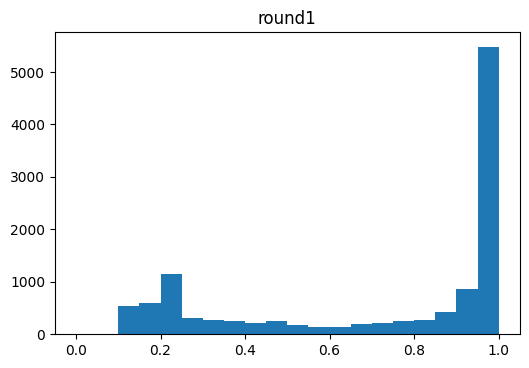

11771 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


In [17]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,X_syn,y_syn,1000,32,5,numVal = 10,numManualPerRound=5,inJupyter=True)

In [18]:
y_val_scores_active = integ.classifyMatrix(X_val)

2/2 [==============================] - 0s 3ms/step


0.9769

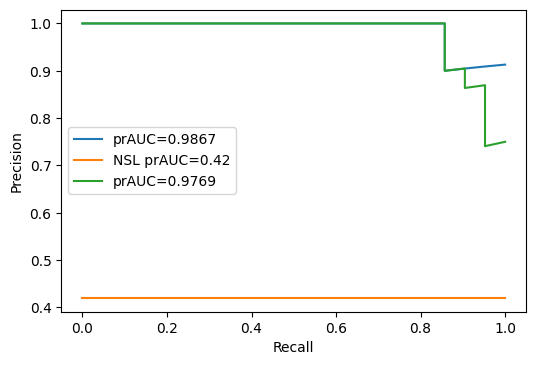

In [19]:
makePRCPlot(y_val_scores_supervised[:,1],y_val[:,1],noSkill=True)
makePRCPlot(y_val_scores_active[:,1],y_val[:,1],noSkill=False)

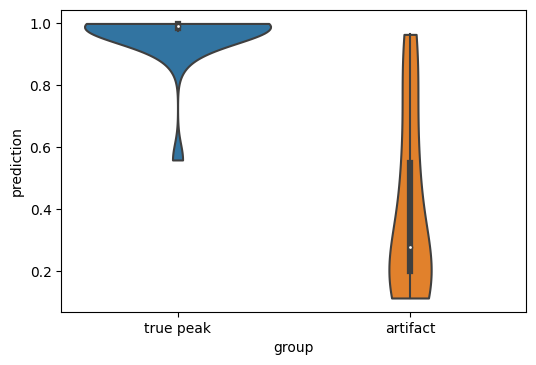

In [21]:
makeViolinPlot(y_val_scores_active[:,1],y_val[:,1])

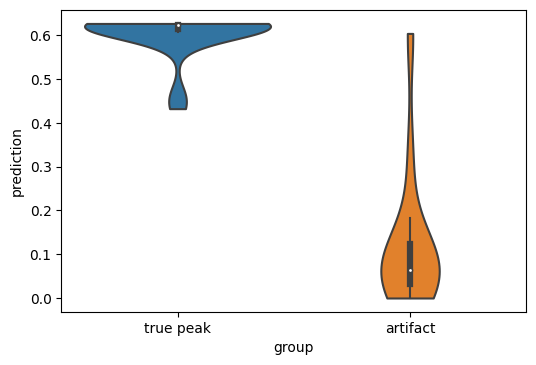

In [23]:
makeViolinPlot(y_val_scores_supervised[:,1],y_val[:,1])

In [24]:
pkl.dump(integ,open(datadir + "PeakDetective.pkl","wb"))

INFO:tensorflow:Assets written to: ram://e2ded3b4-aab7-4522-befa-43381f6e7331/assets


INFO:tensorflow:Assets written to: ram://e2ded3b4-aab7-4522-befa-43381f6e7331/assets


INFO:tensorflow:Assets written to: ram://4df8c4c7-6ac7-4820-a4c0-ea5193781f2d/assets


INFO:tensorflow:Assets written to: ram://4df8c4c7-6ac7-4820-a4c0-ea5193781f2d/assets


INFO:tensorflow:Assets written to: ram://992f77a0-9045-4ae0-9cc6-55d67234faff/assets


INFO:tensorflow:Assets written to: ram://992f77a0-9045-4ae0-9cc6-55d67234faff/assets


In [25]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=0.5)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
369/369 [==============================] - 0s 1ms/step


In [30]:
y = integ.classifyMatrix(X)

369/369 [==============================] - 0s 1ms/step


In [26]:
peak_curated

,mz,rt,../data/covid_plasma/B1_NIST1950_1_6540.mzML,../data/covid_plasma/B1_NIST1950_2_6540.mzML,../data/covid_plasma/B1_NIST1950_3_6540.mzML
1,52.995260,5.082550,0.0,0.0,0.0
2,54.977009,5.083667,1.0,1.0,1.0
3,55.019199,6.030133,0.0,0.0,0.0
4,57.034543,5.399525,0.0,0.0,0.0
5,57.034540,1.583142,1.0,1.0,1.0
...,...,...,...,...,...
3928,1612.974731,6.589500,0.0,0.0,0.0
3929,1612.974770,2.198033,0.0,1.0,0.0
3930,1613.978781,15.015317,0.0,0.0,0.0
3931,1613.978738,2.198033,0.0,1.0,0.0


In [27]:
peak_scores

,mz,rt,../data/covid_plasma/B1_NIST1950_1_6540.mzML,../data/covid_plasma/B1_NIST1950_2_6540.mzML,../data/covid_plasma/B1_NIST1950_3_6540.mzML
1,52.995260,5.082550,0.112396,0.112396,0.112396
2,54.977009,5.083667,0.995470,0.993256,0.993954
3,55.019199,6.030133,0.211067,0.209916,0.208775
4,57.034543,5.399525,0.231685,0.201821,0.204425
5,57.034540,1.583142,0.640380,0.665886,0.565626
...,...,...,...,...,...
3928,1612.974731,6.589500,0.205023,0.199660,0.203277
3929,1612.974770,2.198033,0.197669,0.910820,0.199141
3930,1613.978781,15.015317,0.198544,0.233229,0.201182
3931,1613.978738,2.198033,0.188144,0.856863,0.182448


In [28]:
peak_intensities

,mz,rt,../data/covid_plasma/B1_NIST1950_1_6540.mzML,../data/covid_plasma/B1_NIST1950_2_6540.mzML,../data/covid_plasma/B1_NIST1950_3_6540.mzML
1,52.995260,5.082550,0.000000,0.000000,0.000000
2,54.977009,5.083667,128968.342946,112130.332273,111305.784673
3,55.019199,6.030133,5059.977877,2073.793114,3598.691253
4,57.034543,5.399525,9393.209688,5328.930752,5084.562643
5,57.034540,1.583142,18285.457967,18098.806640,12934.291039
...,...,...,...,...,...
3928,1612.974731,6.589500,15458.825595,25053.053237,49186.802861
3929,1612.974770,2.198033,12536.080663,69533.926945,15130.228773
3930,1613.978781,15.015317,4437.936912,0.000000,4913.898905
3931,1613.978738,2.198033,1715.920833,25275.780261,174.547073


In [29]:
peakList

,mz,rt
1,52.995260,5.082550
2,54.977009,5.083667
3,55.019199,6.030133
4,57.034543,5.399525
5,57.034540,1.583142
...,...,...
3928,1612.974731,6.589500
3929,1612.974770,2.198033
3930,1613.978781,15.015317
3931,1613.978738,2.198033


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


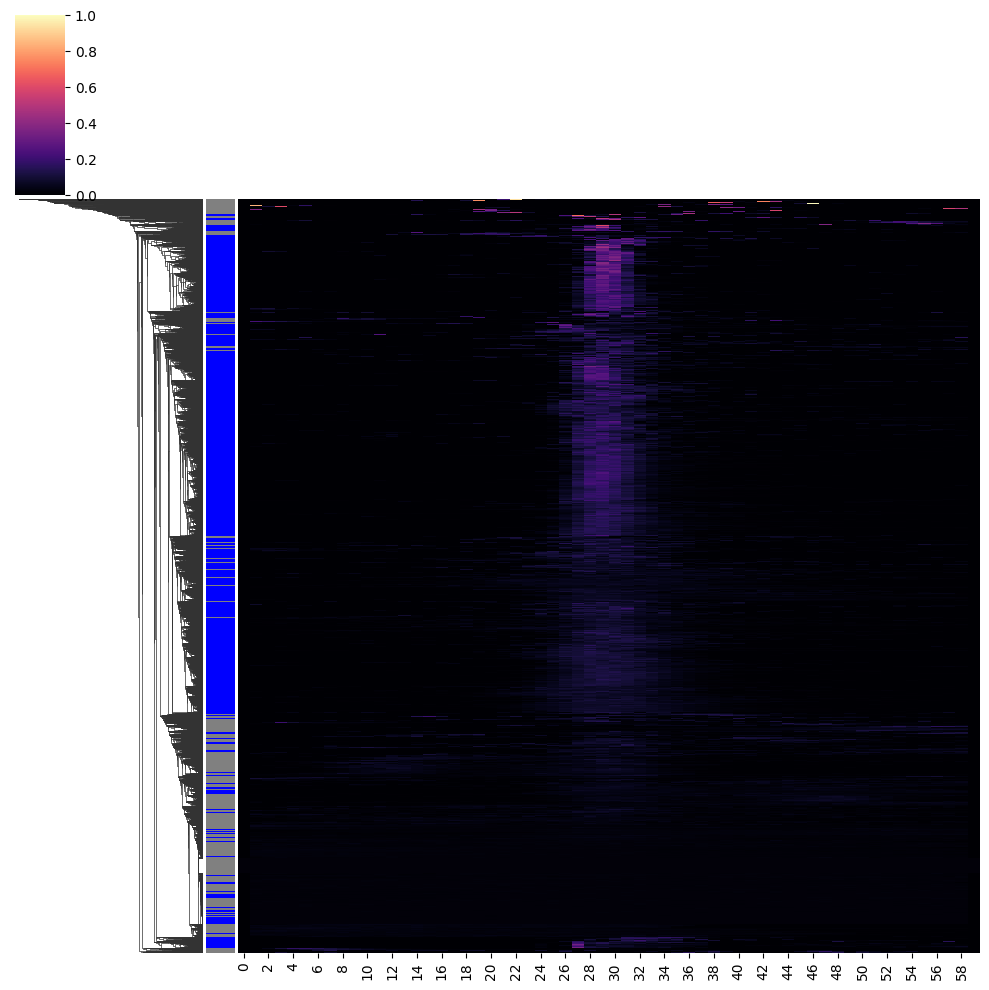

In [32]:
def tmp(val):
    if val > 0.5:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:,1]]
sb.clustermap(PeakDetective.normalizeMatrix(X),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)

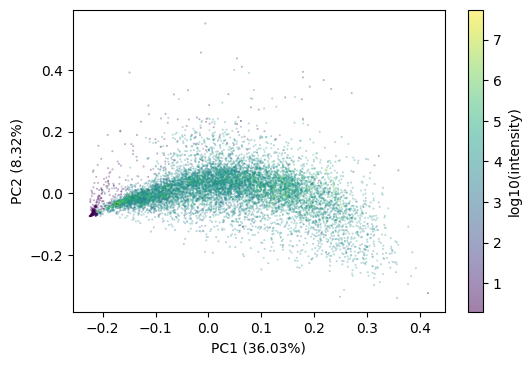

In [33]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

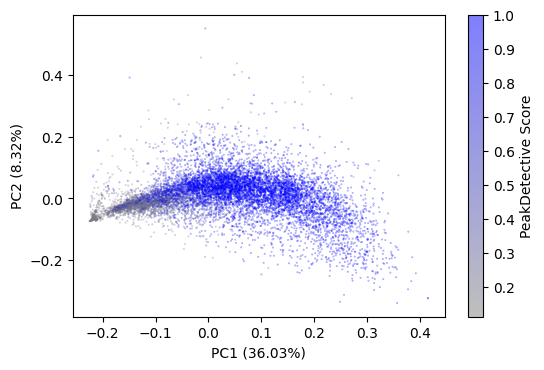

In [35]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="PeakDetective Score")

Text(0, 0.5, '% of features')

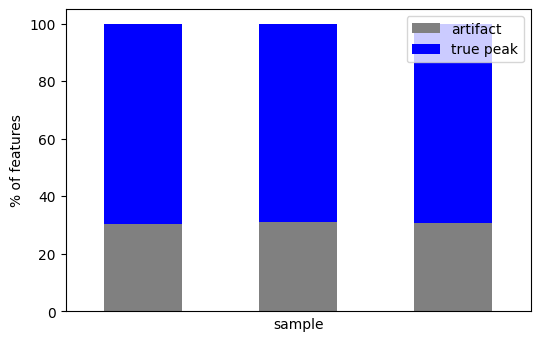

In [38]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > 0.5:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


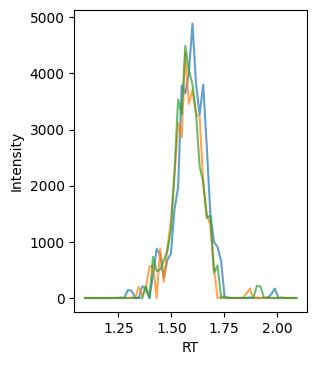

In [40]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

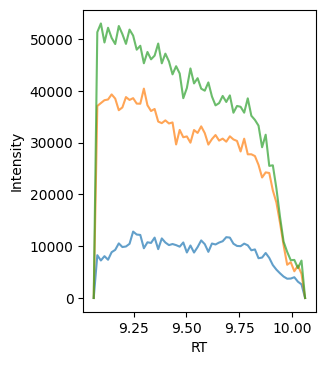

In [42]:
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [43]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if peak_curated.at[index,datadir + file] > 0.5:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)

array([[140,  64],
       [ 16, 280]], dtype=int64)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


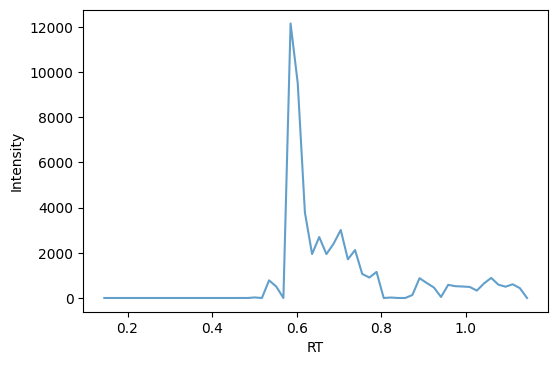

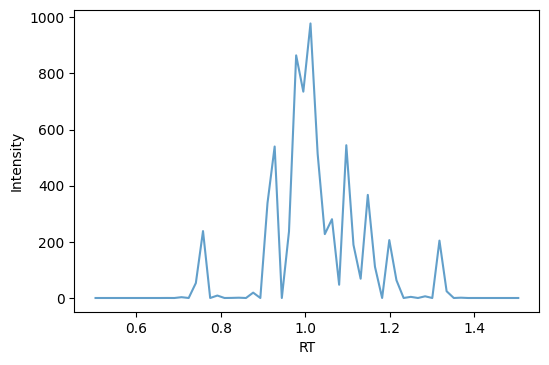

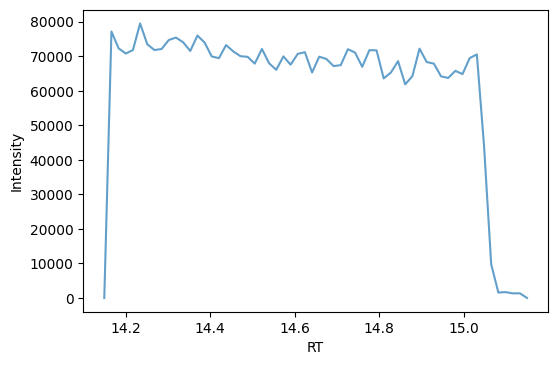

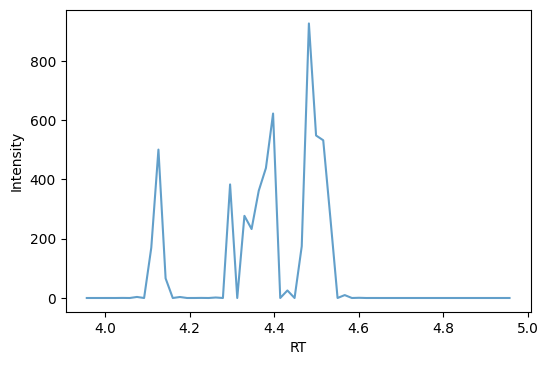

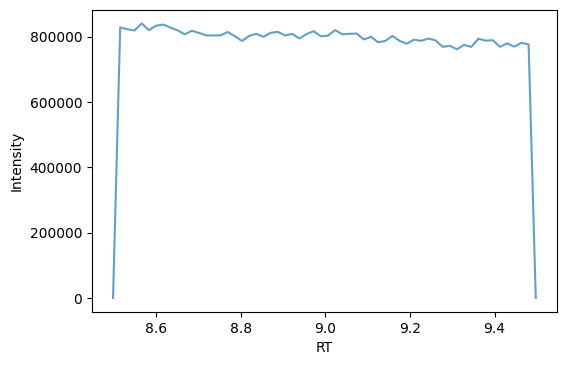

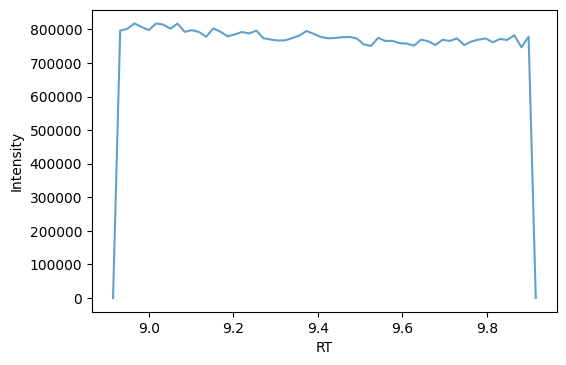

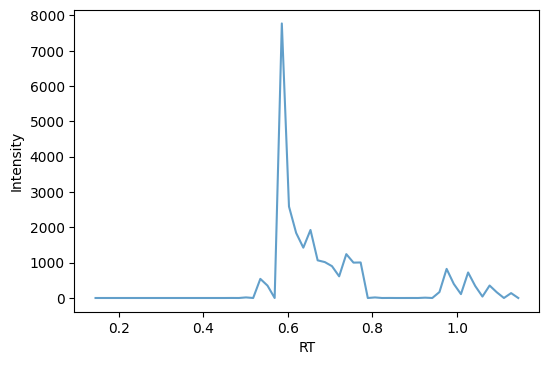

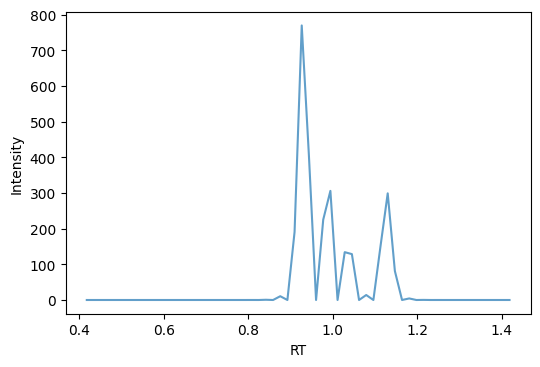

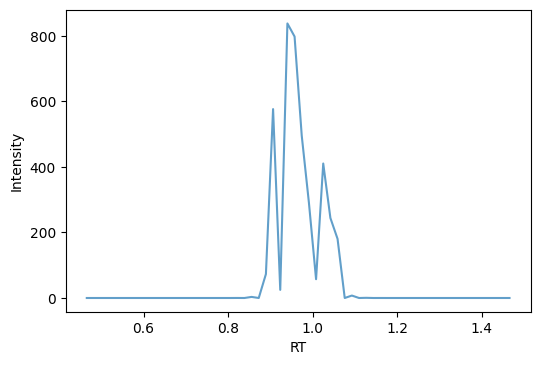

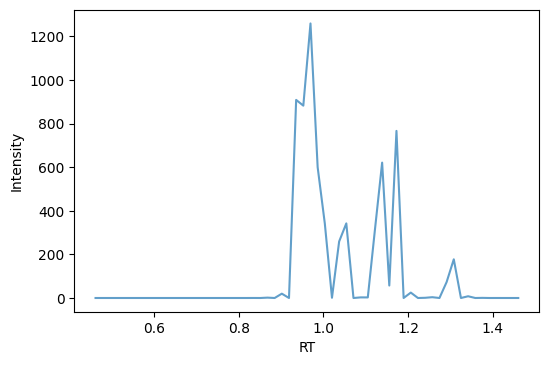

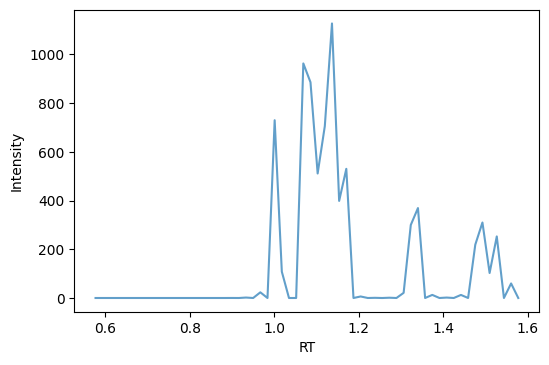

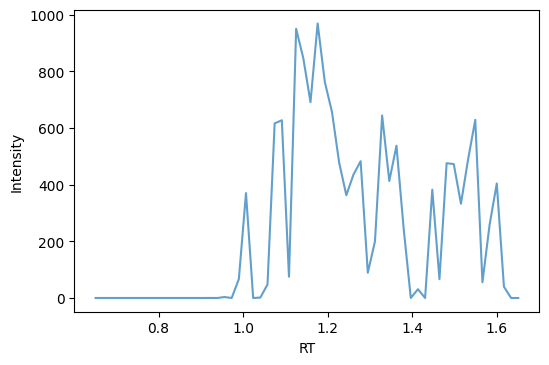

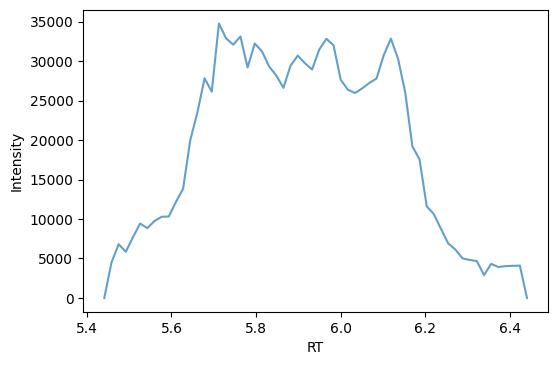

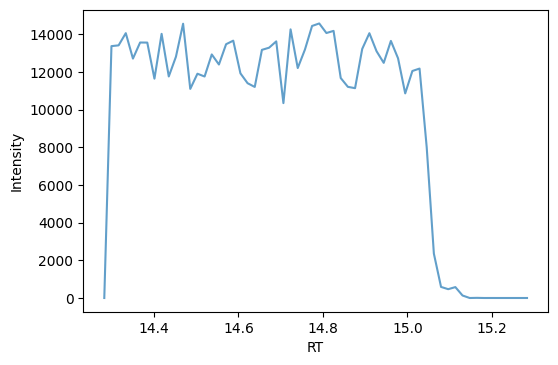

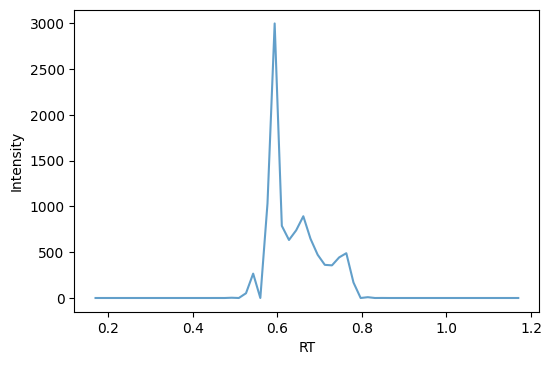

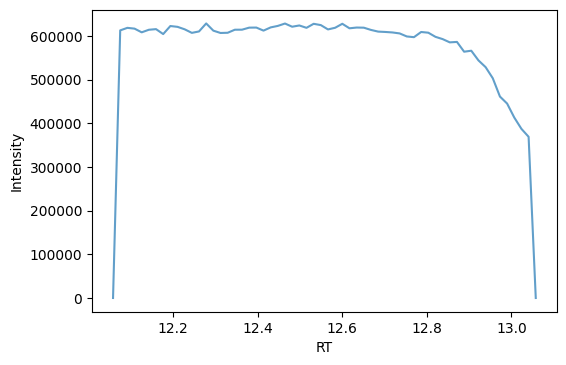

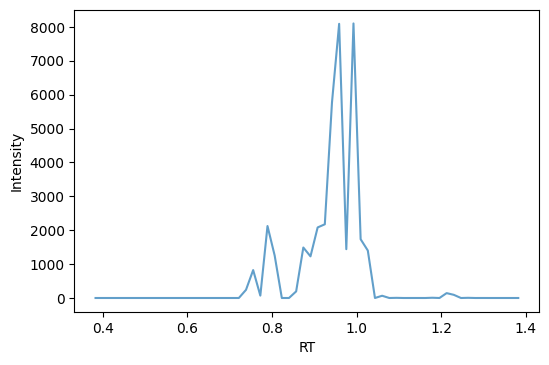

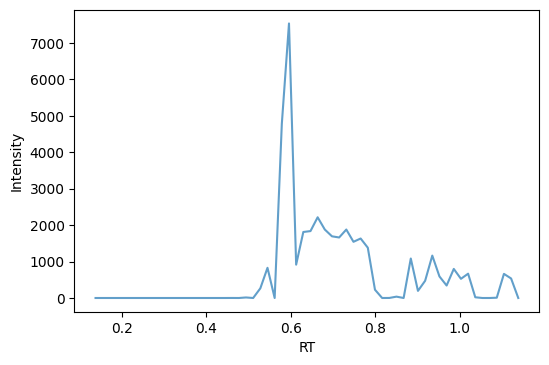

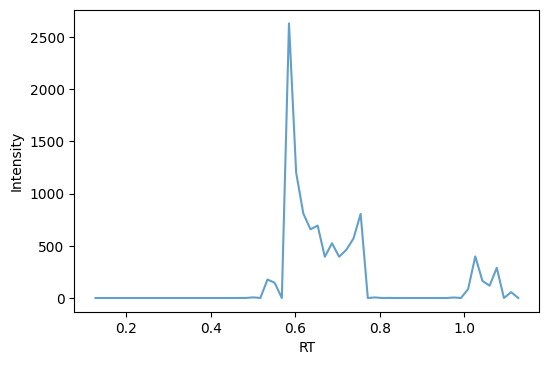

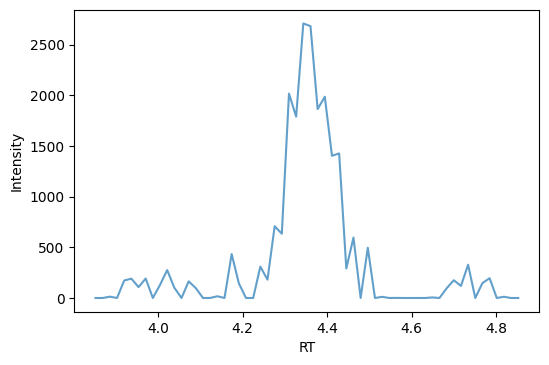

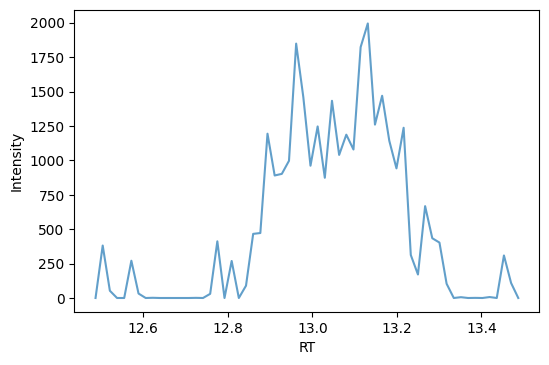

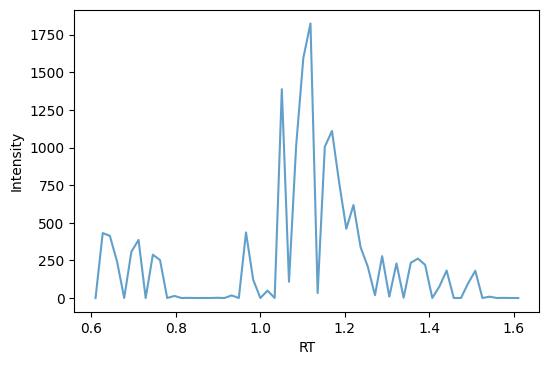

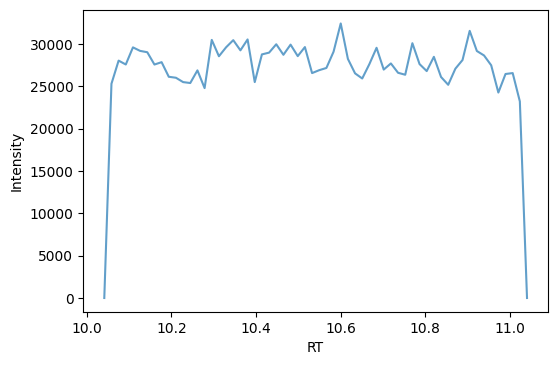

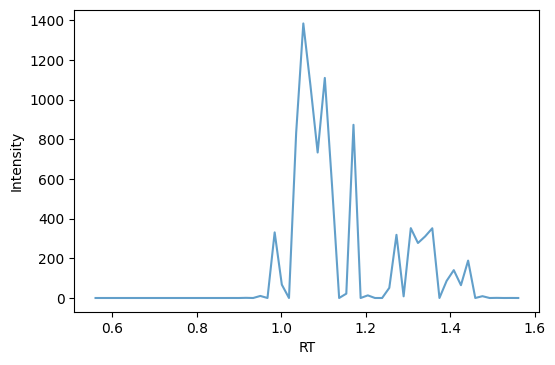

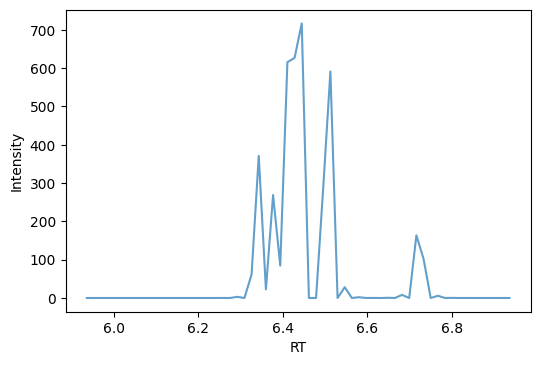

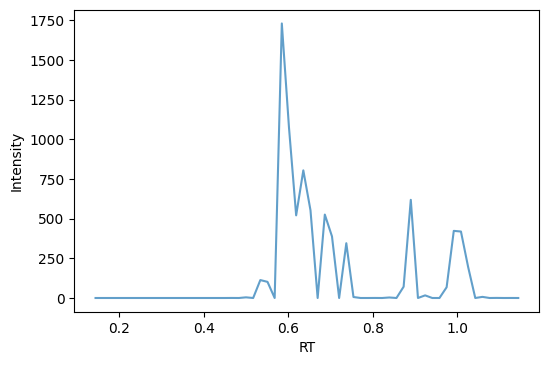

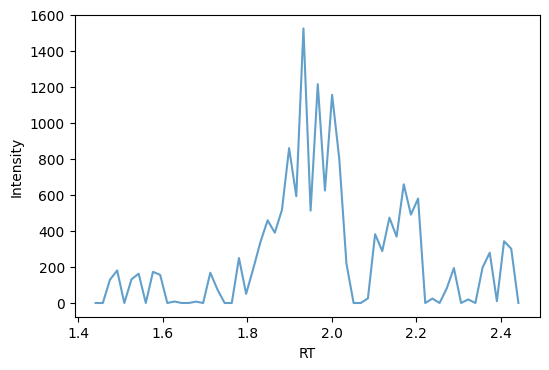

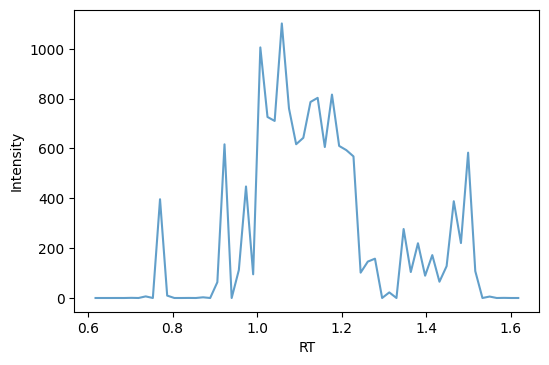

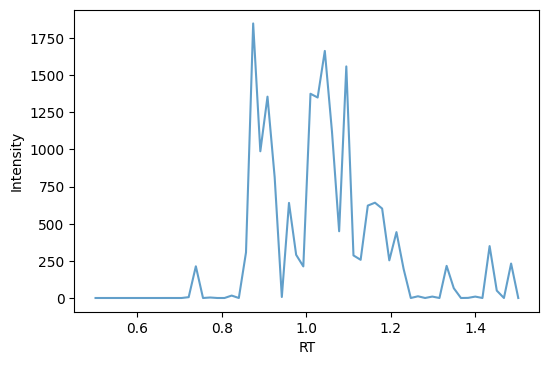

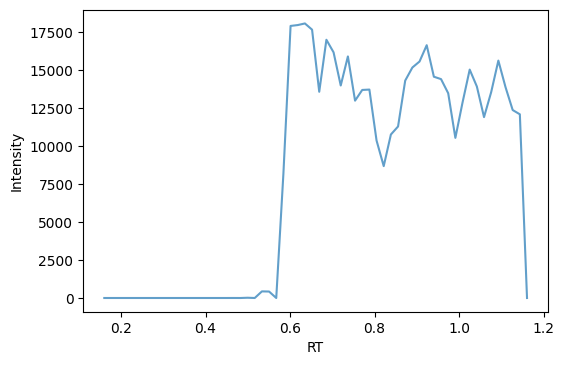

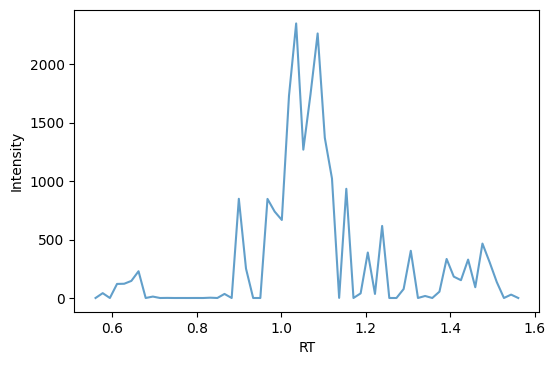

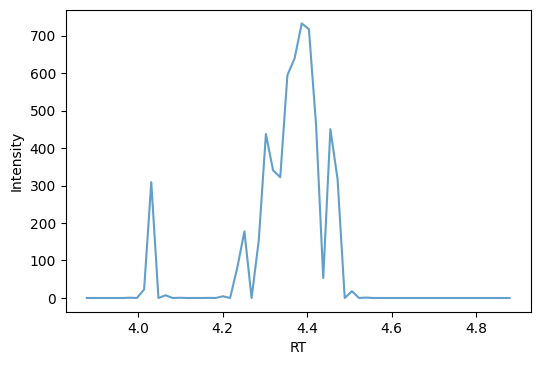

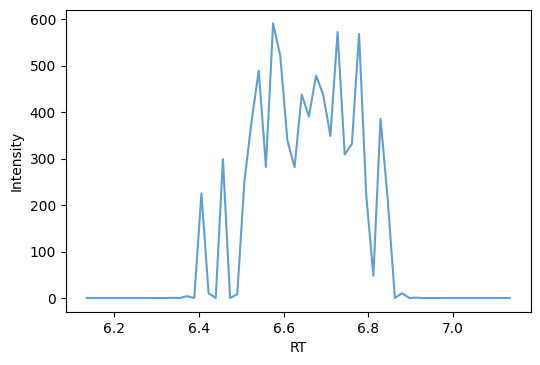

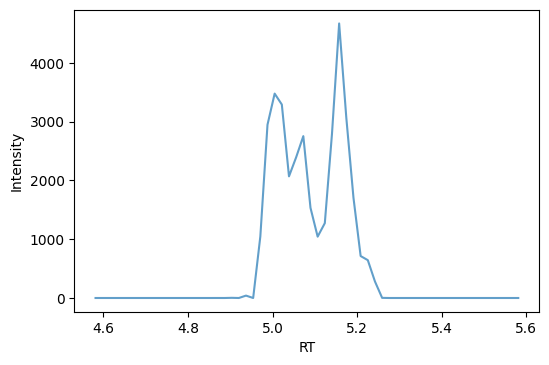

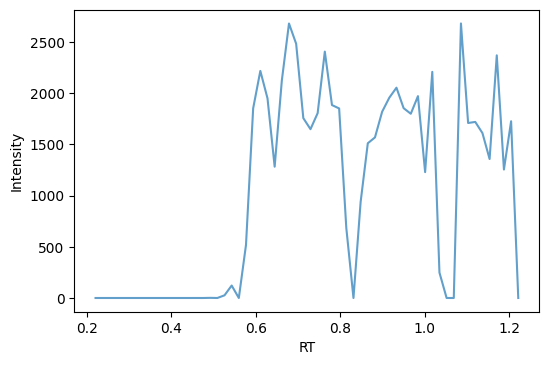

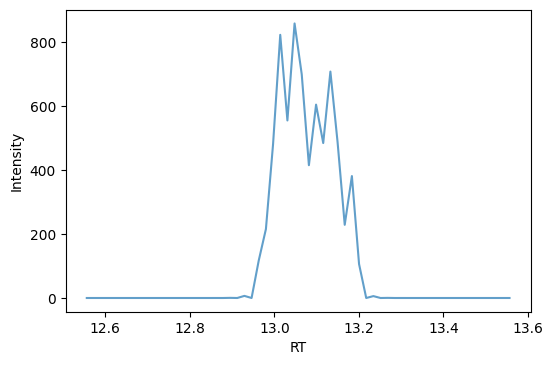

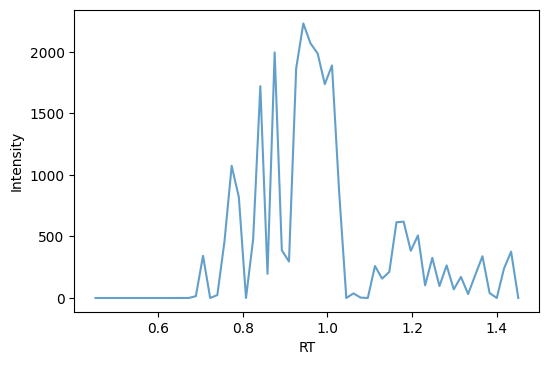

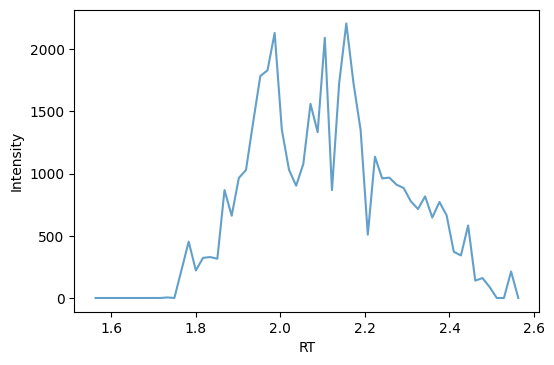

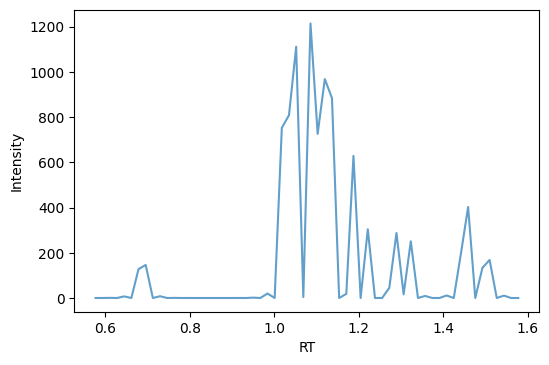

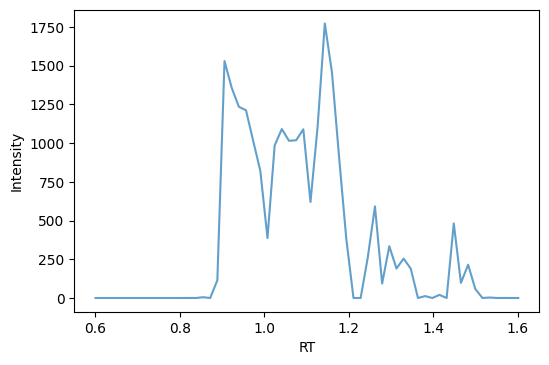

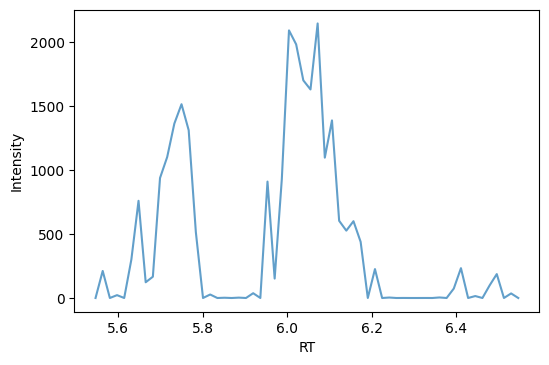

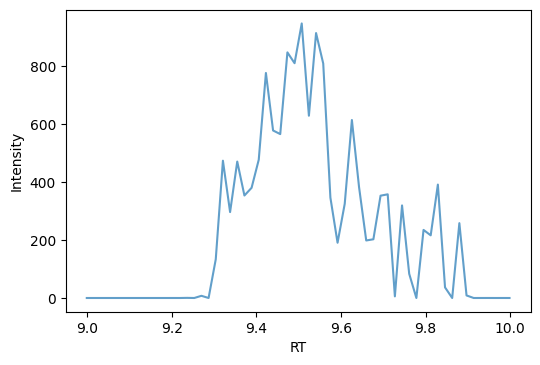

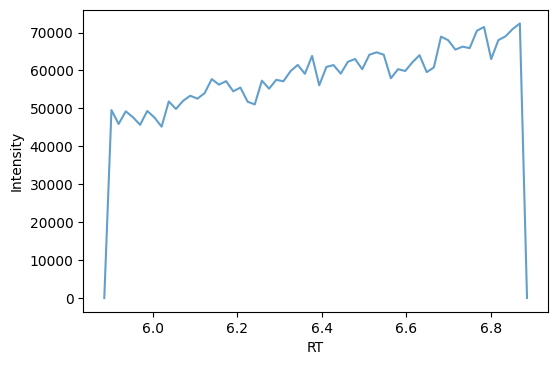

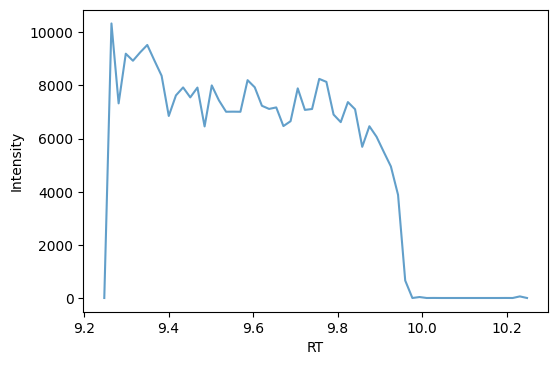

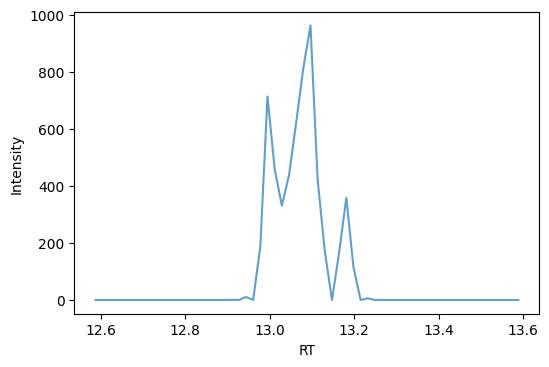

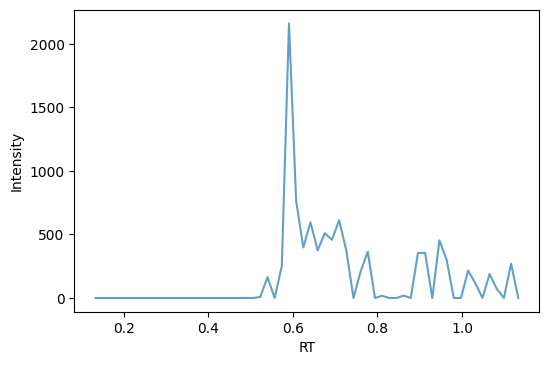

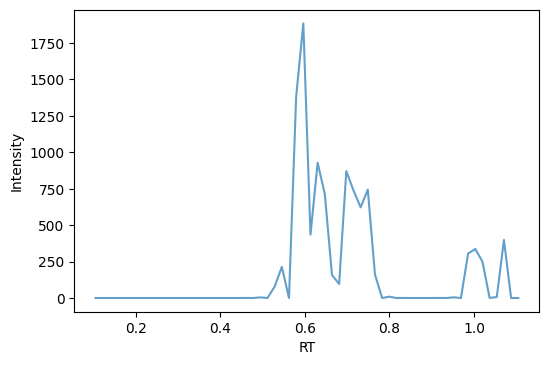

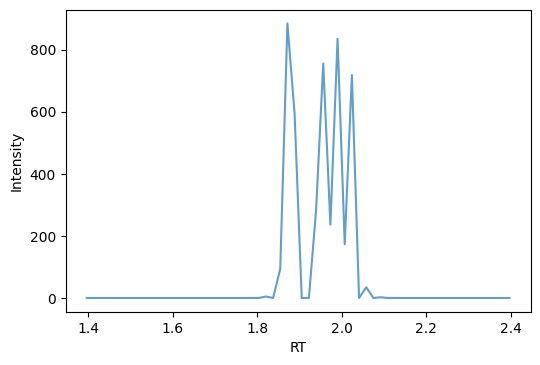

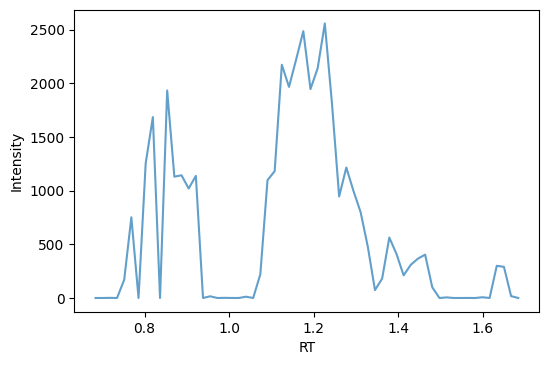

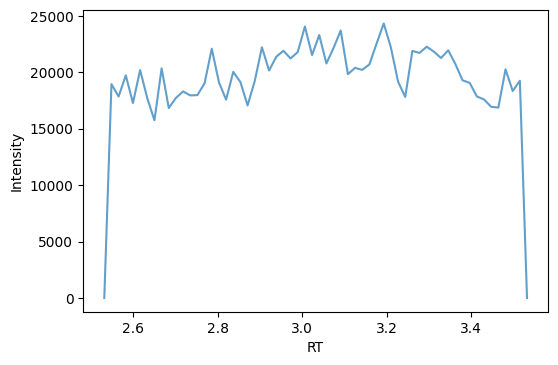

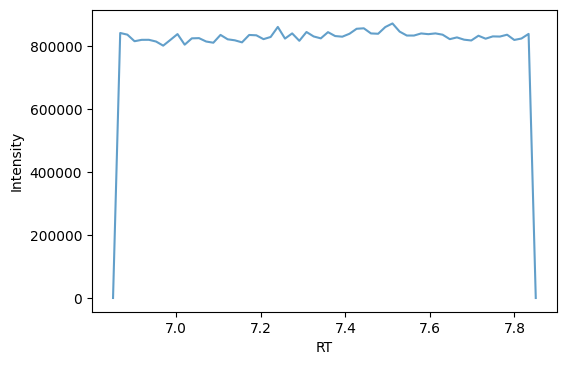

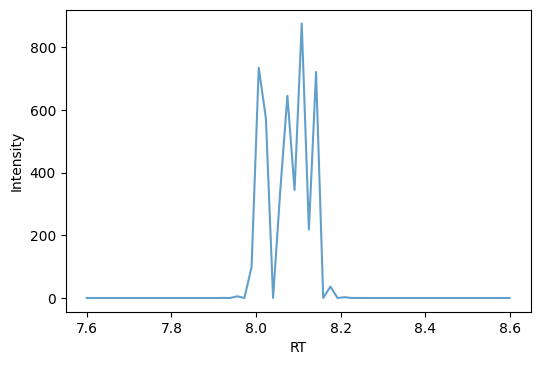

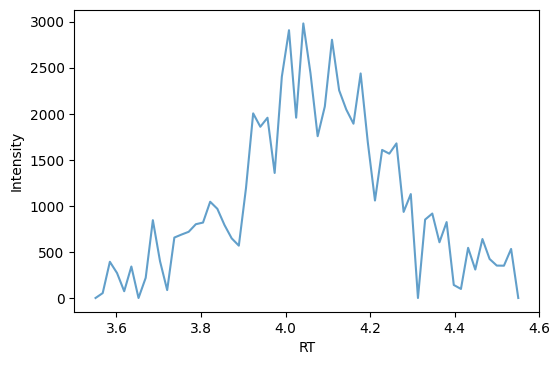

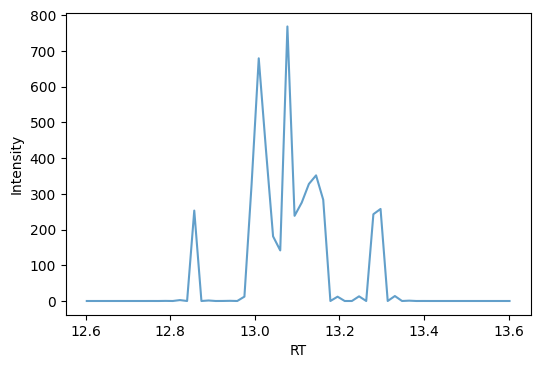

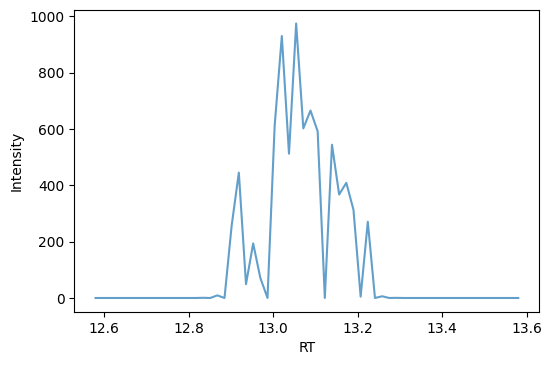

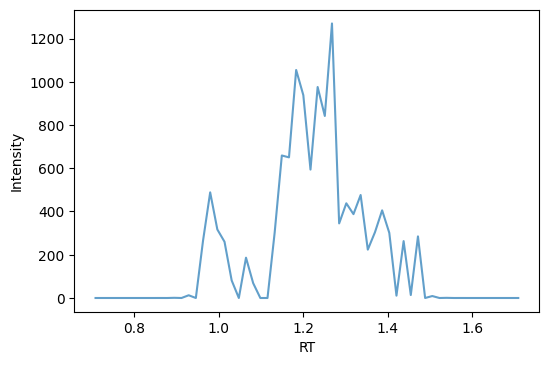

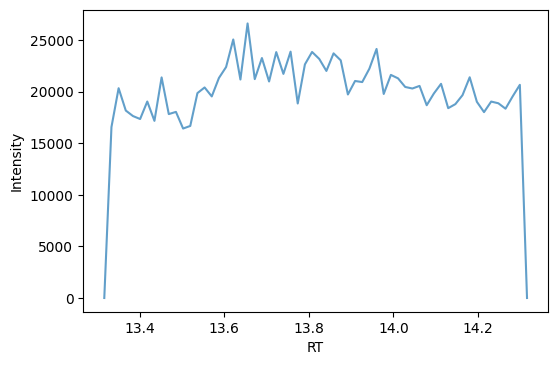

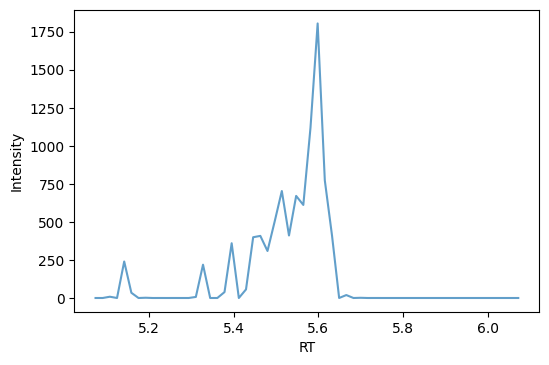

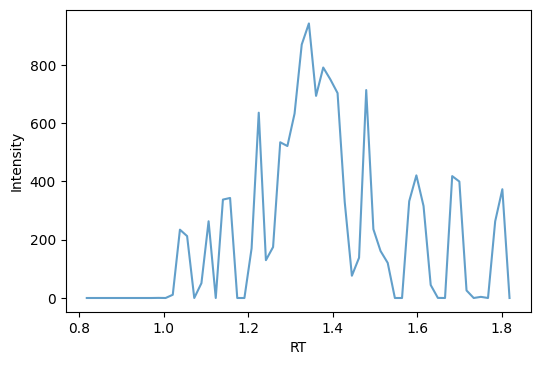

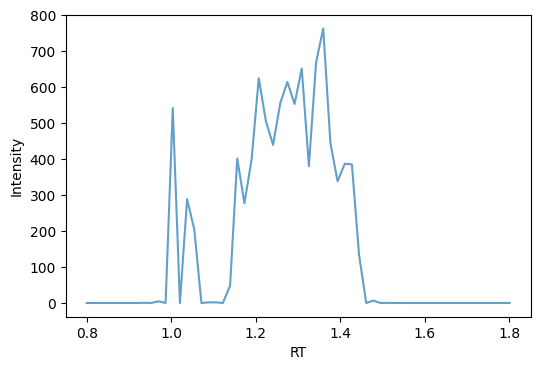

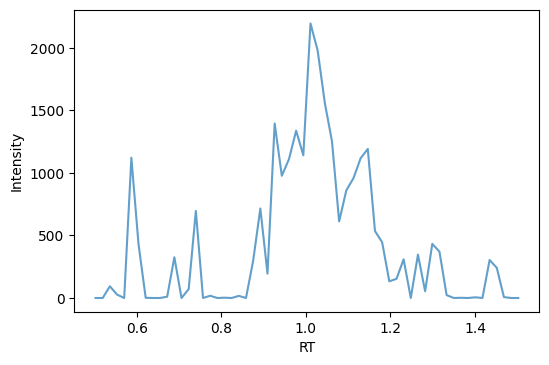

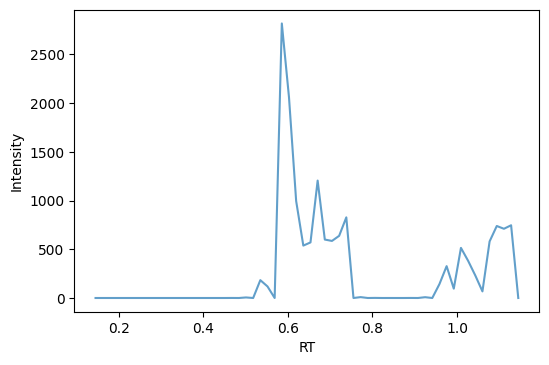

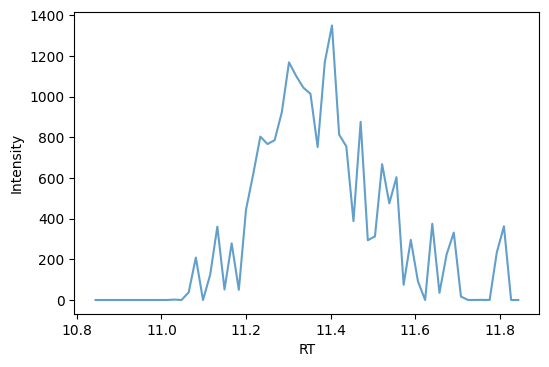

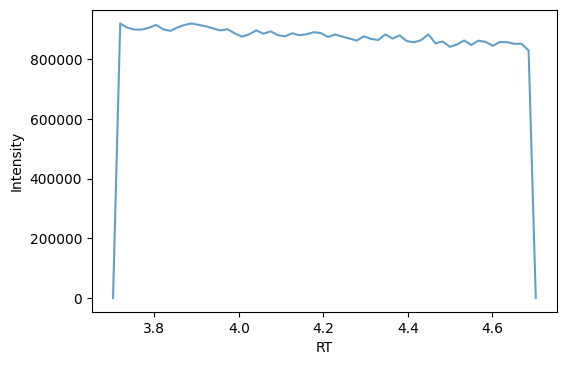

<Figure size 600x400 with 0 Axes>

In [44]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

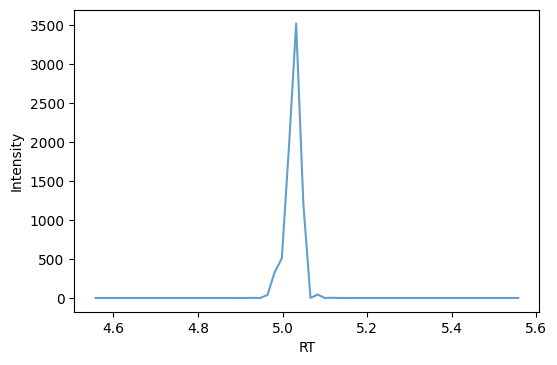

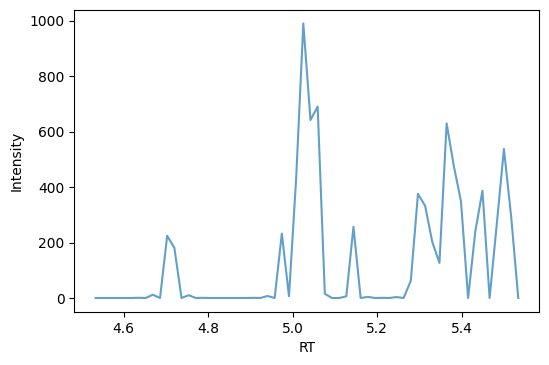

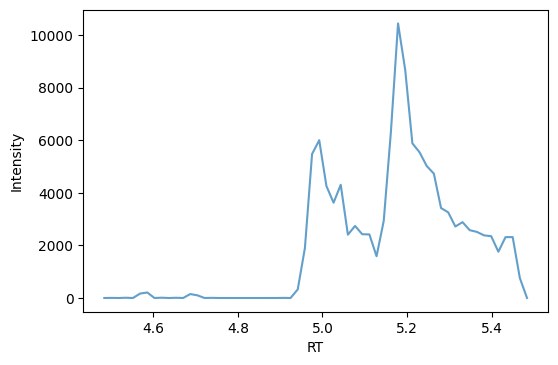

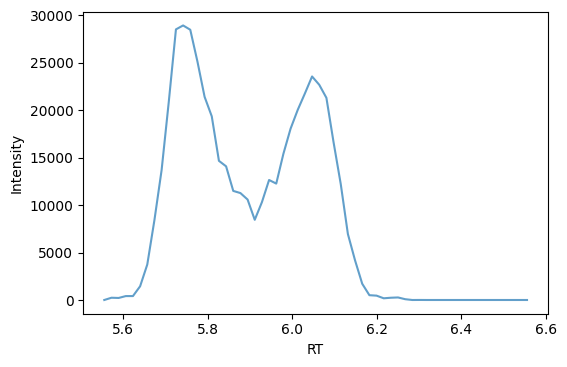

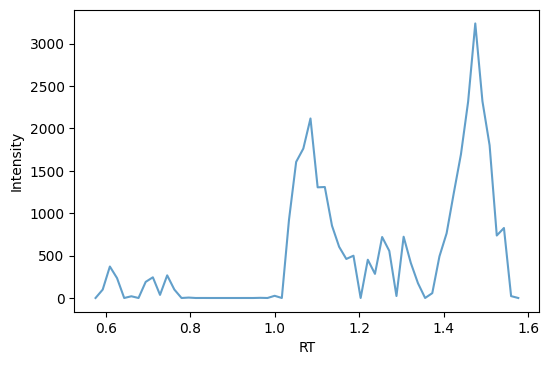

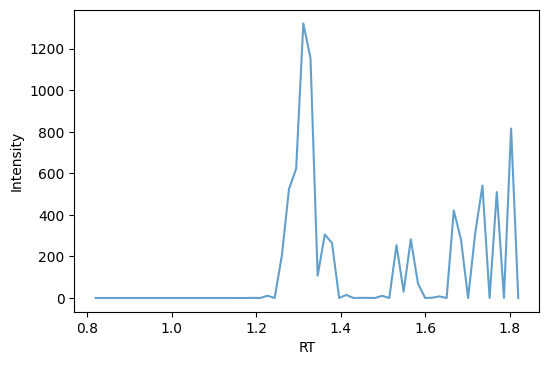

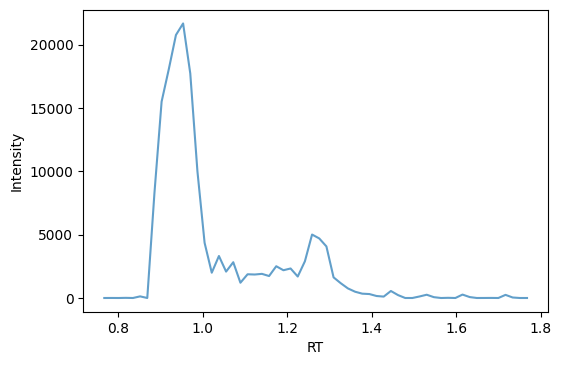

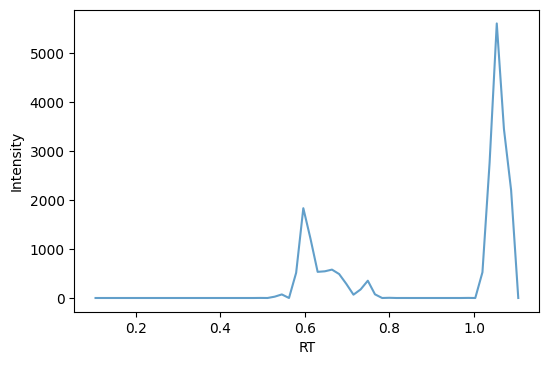

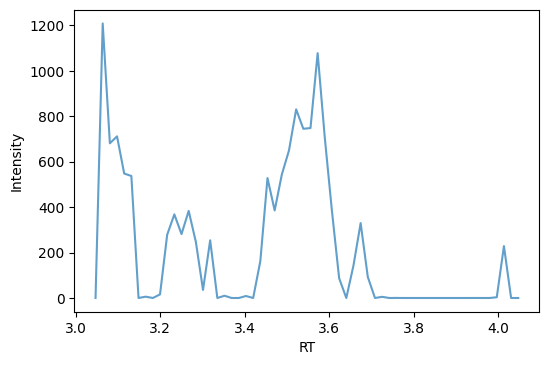

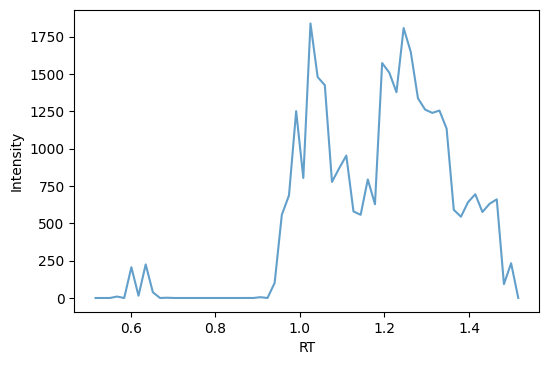

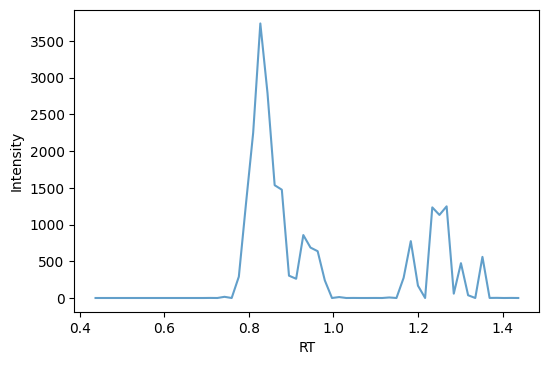

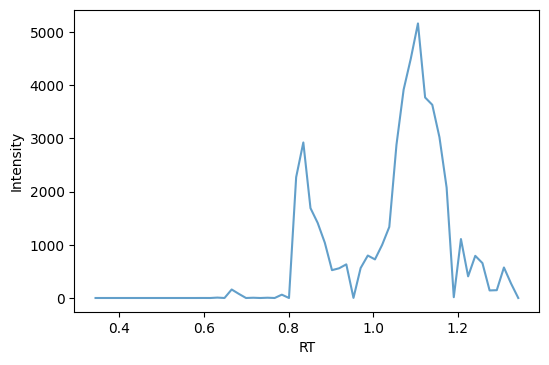

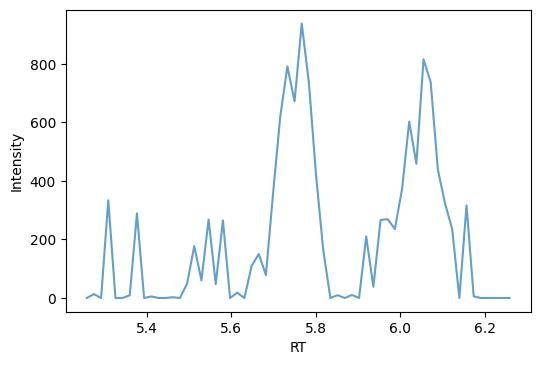

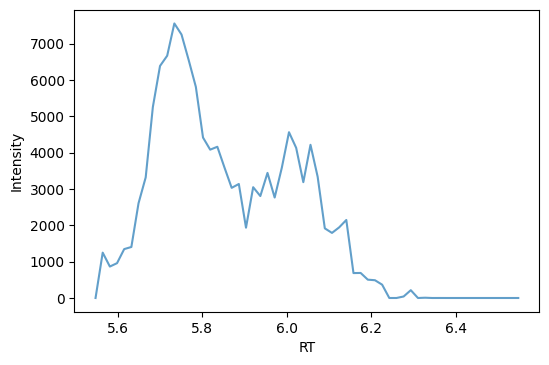

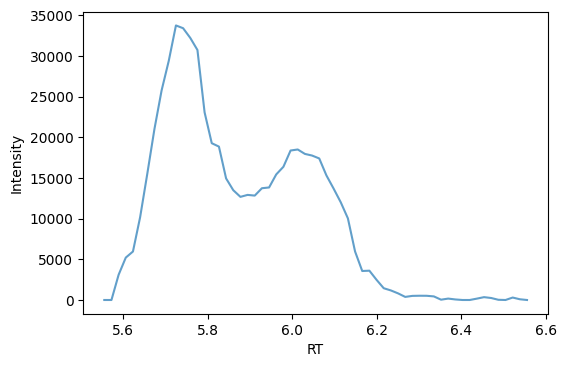

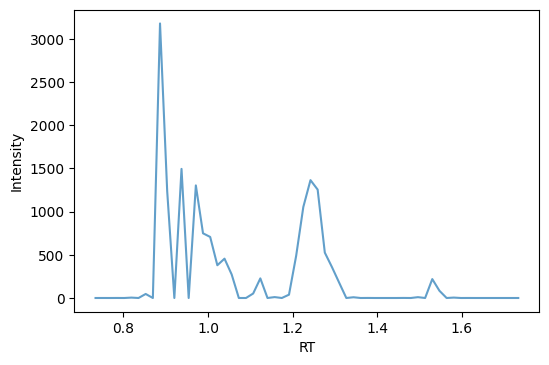

<Figure size 600x400 with 0 Axes>

In [45]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

0.57

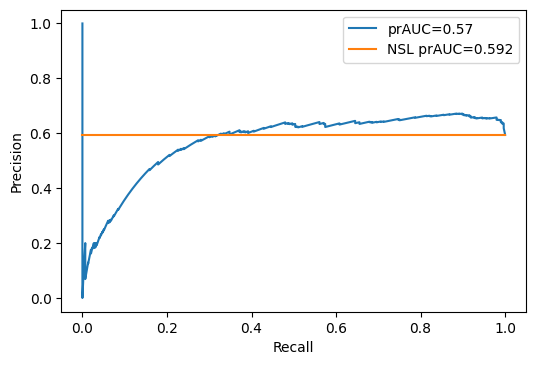

In [46]:
trueInt = []
predInt = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    predInt.append(peak_intensities.at[index,datadir+file])
    trueInt.append(row["classification"])

makePRCPlot(predInt,trueInt)

In [51]:
len(predCV)

492

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


0.6949

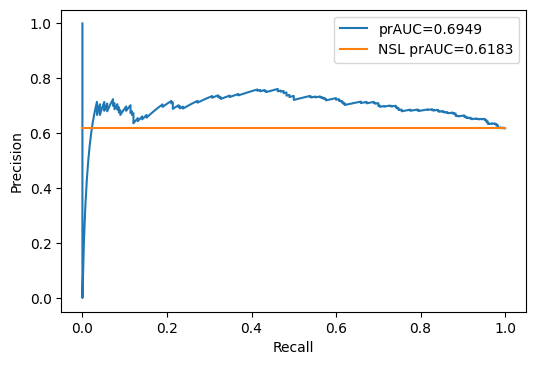

In [56]:
trueCV = []
predCV = []
for index,row in peakList_labeled.iterrows():
    ints = [peak_intensities.at[index,datadir+file] for file in files]
    cv = 1 - np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0:
        predCV.append(cv)
        trueCV.append(row["classification"])

makePRCPlot(predCV,trueCV)


0.6949

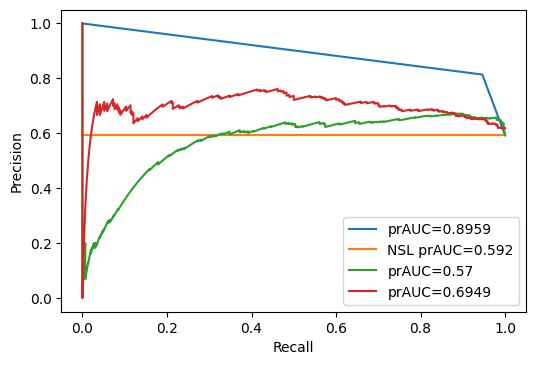

In [57]:
makePRCPlot(pred,true)
makePRCPlot(predInt,trueInt,False)
makePRCPlot(predCV,trueCV,False)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='classification', ylabel='CV'>

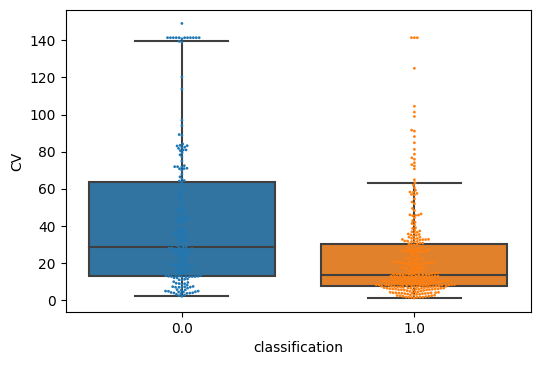

In [58]:
plt_df = {}
for index,row in peakList_labeled.iterrows():
    ints = [peak_intensities.at[index,datadir+file] for file in files]
    cv = 100 * np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0:
        plt_df[len(plt_df)] = {"classification":row["classification"],"CV":cv}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="CV",s=2)
sb.boxplot(data=plt_df,x="classification",y="CV",fliersize=0)

<AxesSubplot:xlabel='classification', ylabel='intensity'>

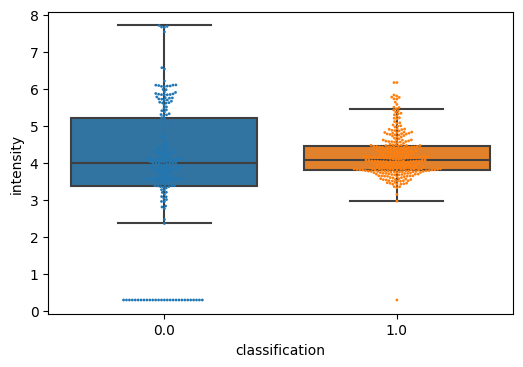

In [60]:
plt_df = {}
file = files[0]
np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X]))
for index,row in peakList_labeled.iterrows():
    plt_df[len(plt_df)] = {"classification":row["classification"],"intensity":np.log10(np.max([2,peak_intensities.at[index,datadir+file]]))}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="intensity",s=2)
sb.boxplot(data=plt_df,x="classification",y="intensity",fliersize=0)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='classification', ylabel='Peak Score'>

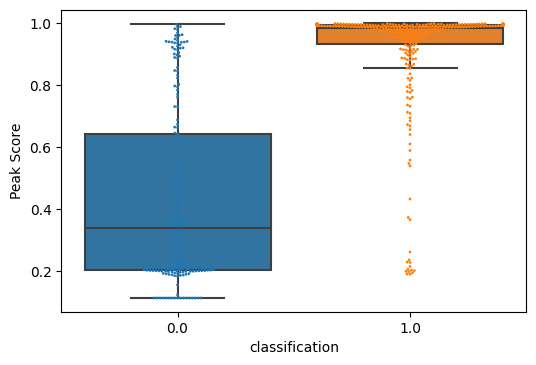

In [61]:
plt_df = {}
file = files[0]
for index,row in peakList_labeled.iterrows():
    plt_df[len(plt_df)] = {"classification":row["classification"],"Peak Score":peak_scores.at[index,datadir+file]}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="Peak Score",s=2)
sb.boxplot(data=plt_df,x="classification",y="Peak Score",fliersize=0)

In [65]:
skyline_peak_areas = pd.read_csv(datadir + "skyline_peak_areas.csv").fillna(0.0)
skyline_peak_areas

,Molecule Name,Precursor Charge,Precursor Mz,Explicit Retention Time,B1_NIST1950_1_6540 Area,B1_NIST1950_2_6540 Area,B1_NIST1950_3_6540 Area
0,unknown 1,-1,52.995260,5.08,0.0,0.0,0.0
1,unknown 2,-1,54.977009,5.08,142831.0,112434.0,116693.0
2,unknown 3,-1,55.019199,6.03,7133.0,9502.0,8776.0
3,unknown 4,-1,57.034543,5.40,13263.0,8888.0,11325.0
4,unknown 5,-1,57.034540,1.58,25775.0,21628.0,17478.0
...,...,...,...,...,...,...,...
3927,unknown 3928,-1,1612.974731,6.59,21431.0,4094.0,3857.0
3928,unknown 3929,-1,1612.974770,2.20,3309.0,118996.0,1568.0
3929,unknown 3930,-1,1613.978781,15.02,4898.0,38277.0,10090.0
3930,unknown 3931,-1,1613.978738,2.20,1855.0,48796.0,3229.0


In [66]:
data_mat_peak_areas_skyline = skyline_peak_areas[skyline_peak_areas.columns.values[4:]].values
data_mat_peak_areas_skyline.shape

(3932, 3)

In [67]:
peak_intensities

,mz,rt,../data/covid_plasma/B1_NIST1950_1_6540.mzML,../data/covid_plasma/B1_NIST1950_2_6540.mzML,../data/covid_plasma/B1_NIST1950_3_6540.mzML
1,52.995260,5.082550,0.000000,0.000000,0.000000
2,54.977009,5.083667,128968.342946,112130.332273,111305.784673
3,55.019199,6.030133,5059.977877,2073.793114,3598.691253
4,57.034543,5.399525,9393.209688,5328.930752,5084.562643
5,57.034540,1.583142,18285.457967,18098.806640,12934.291039
...,...,...,...,...,...
3928,1612.974731,6.589500,15458.825595,25053.053237,49186.802861
3929,1612.974770,2.198033,12536.080663,69533.926945,15130.228773
3930,1613.978781,15.015317,4437.936912,0.000000,4913.898905
3931,1613.978738,2.198033,1715.920833,25275.780261,174.547073


In [69]:
peak_areas_peak_detective = peak_intensities[peak_intensities.columns.values[2:]].values
peak_areas_peak_detective.shape

(3932, 3)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


0.3023988693339338

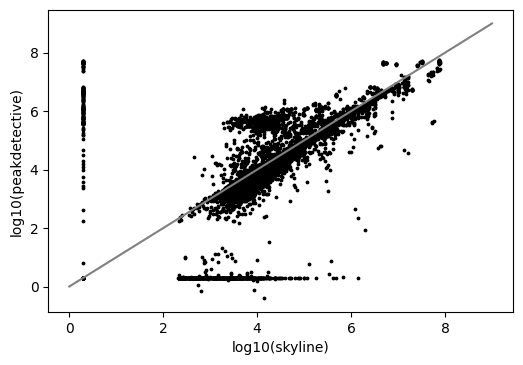

In [75]:
plt.scatter(np.log10(data_mat_peak_areas_skyline.flatten()+2),np.log10(peak_areas_peak_detective.flatten() + 2),color="black",s=3)
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(skyline)")
plt.ylabel("log10(peakdetective)")
met.r2_score(data_mat_peak_areas_skyline.flatten(),peak_areas_peak_detective.flatten())